In [1]:
import nest
dir (nest)

['BeginSubnet',
 'CGConnect',
 'CGParse',
 'CGSelectImplementation',
 'ChangeSubnet',
 'Cleanup',
 'Connect',
 'ConnectionRules',
 'CopyModel',
 'Create',
 'CurrentSubnet',
 'DataConnect',
 'DisableStructuralPlasticity',
 'Disconnect',
 'DisconnectOneToOne',
 'EnableStructuralPlasticity',
 'EndSubnet',
 'GetChildren',
 'GetConnections',
 'GetDefaults',
 'GetKernelStatus',
 'GetLID',
 'GetLeaves',
 'GetNetwork',
 'GetNodes',
 'GetStatus',
 'GetStructuralPlasticityStatus',
 'Install',
 'LayoutNetwork',
 'Models',
 'NumProcesses',
 'Prepare',
 'PrintNetwork',
 'Rank',
 'ResetKernel',
 'ResetNetwork',
 'Run',
 'RunManager',
 'SetAcceptableLatency',
 'SetDefaults',
 'SetKernelStatus',
 'SetMaxBuffered',
 'SetStatus',
 'SetStructuralPlasticityStatus',
 'Simulate',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'authors',
 'get_verbosity',
 'help',
 'helpdesk',
 'hl_api',
 'import_libs',
 'kernel',
 'lib',
 'll_a

In [2]:
nest.Models

<function nest.lib.hl_api_models.Models(mtype='all', sel=None)>

In [3]:
import nest
neuron = nest.Create("iaf_psc_alpha")
nest.GetStatus(neuron)
nest.GetStatus(neuron,"I_e")
nest.GetStatus(neuron,["V_reset","V_th"])
nest.SetStatus(neuron,{"I_e": 376.0})

# Multimeter, this is a device that can be used to record the neuron membrane voltage changes with time
multimeter = nest.Create("multimeter")
# Set the time of its property so that it will also record the time point of membrane voltage sampling
# The record_from attribute requires a list of names of the variables we want to record
# The variables exposed to the multimeter vary by model 
# For a specific model, you can check the name of the exposed variable by looking at the recordable properties of the neuron 
nest.SetStatus(multimeter,{"withtime":True,"record_from":["V_m"]})

# Create a spike detector and another device to record spikes generated by neurons
# Use the optional keyword parameter params to set its properties, which is an alternative to using SetStatus()
# The attribute withgid indicates whether the spike detector records the source ID (neuron ID) from which it received the event
spikedetector = nest.Create("spike_detector",params={"withgid":True,"withtime":True})

# The order of specifying connection parameters reflects the flow of events: 
# The multimeter periodically sends a request to the neuron to interrogate its membrane potential at that time
#This can be considered as the perfect electrode stuck in the neuron
nest.Connect(multimeter,neuron)
# Neuron spike, sends an event to the spike detector 
nest.Connect(neuron,spikedetector)

# we have to notice the simulation kernal the simulation running time, here we set 1000ms
nest.Simulate(1000.0)

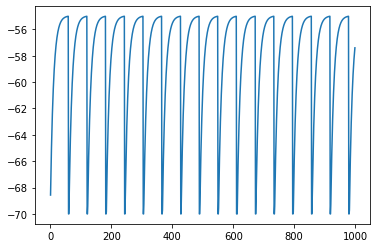

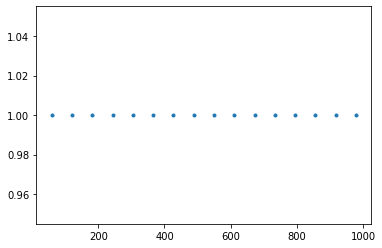

In [4]:
# Get the data recorded by the multimeter
# Get a list of status dictionaries for all query nodes
# Here, the variable multimeter is just one node ID, so the returned list contains only one dictionary
# We index it to extract the first element of this list (hence the last [0]) 
dmm = nest.GetStatus(multimeter)[0]
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

import pylab
pylab.figure(1)
pylab.plot(ts, Vms)
dSD = nest.GetStatus(spikedetector,keys="events")[0]
evs = dSD["senders"]
ts = dSD["times"]
pylab.figure(2)
pylab.plot(ts, evs, ".")
pylab.show()

In [5]:
neuron2 = nest.Create("iaf_psc_alpha")
nest.SetStatus(neuron2,{"I_e":370.0})
nest.Connect(multimeter,neuron2)

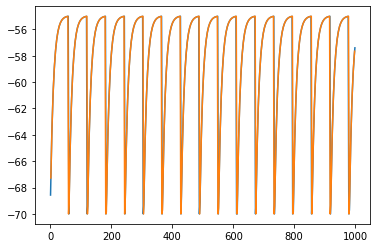

In [6]:
pylab.figure(2)
#start at index 0 : till the end : each 2nd entry
Vms1 = dmm["events"]["V_m"][: : 2]
ts1 = dmm["events"]["times"][: : 2]
pylab.plot(ts1,Vms1)
#start at index 0 : till the end : each 2nd entry
Vms2 = dmm["events"]["V_m"][1: : 2]
ts2 = dmm["events"]["times"][1: : 2]
pylab.plot(ts2,Vms2)

In [7]:
"""
One neuron with noise
----------------------
This script simulates a neuron with input from the Poisson generator, and
records the neuron's membrane potential.
KEYWORDS: iaf_psc_alpha, Poisson generator, voltmeter
"""

import nest
import nest.voltage_trace

nest.set_verbosity("M_WARNING") # only show warning
nest.ResetKernel() # reset kennel would remove any nodes we may have created previously and reset the interkeenel clock to 0
                          # This allows us to execute the script several times in a python shell without interference from previous NEST simulator

# create neuron/poisson generator/voltmeter by Create()
# store the returned handles in variables for later reference 
neuron = nest.Create("iaf_psc_alpha")
noise = nest.Create("poisson_generator", 2)
voltmeter = nest.Create("voltmeter")


In [8]:
# using SetStatus() to configure the Poisson genertor and voltmeter
# It expects a list of node handles and a list of parameter dictionaries.
# Because there is satisfactory defaults so we needn't to set params for neuron
# We set each Poisson generator to 8 000 Hz and 15 000 Hz, respectively
# we want to record the glpbal id of the observed nodes and set the "withgid" flag of the voltmeter to "True"
# We also set its property `withtime` so it will also record the points in time at which it samples the membrane voltage

nest.SetStatus(noise, [{"rate": 80000.0}, {"rate": 15000.0}])
nest.SetStatus(voltmeter,{"withgid": True, "withtime": True})


In [9]:
# the neuron is connected to the poisson generator and the voltmeter 
# we also specify the synaptic weight in this step

nest.Connect(noise, neuron, syn_spec={'weight': [[1.2, -1.0]], 'delay': 1.0})
nest.Connect(voltmeter, neuron)

In [10]:
# using 'Simulate()' to simulate the network 
# It takes the desired simulation time in milliseconds 

nest.Simulate(1000.0)


[[<matplotlib.lines.Line2D at 0x11ca9ef10>]]

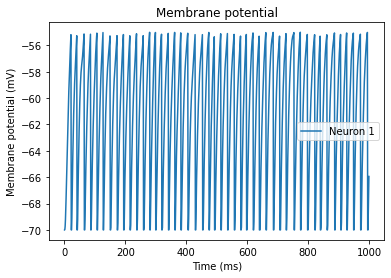

In [11]:
# plot the neuron's membrane potential as a function of time 
nest.voltage_trace.from_device(voltmeter)

In [12]:
'''
A common neural activity model -- the Poisson process
We want the neuron to receive 2 Poisson spikes, one is excitable and the other is inhibitory
Therefore, we need a new device poisson_generator
After creating the neurons, we create these two generators and set their rates to 80000 Hz and 15000 Hz
'''
neuron = nest.Create("iaf_psc_alpha")
noise_ex = nest.Create("poisson_generator")
noise_in = nest.Create("poisson_generator")
nest.SetStatus(noise_ex,{"rate": 80000.0})
nest.SetStatus(noise_in,{"rate": 15000.0})
nest.SetStatus(neuron, {"I_e": 0.0}) # Constant input current should be set to 0

# Each event of the exciter generator should produce a post-synaptic current with an amplitude of 1.2 pA
# an inhibitory event of approximately -2.0 pA
# Synaptic weights can be defined in a dictionary, which is passed to the Connect function using the syn_spec ()
# In general, all parameters that determine synapse can be specified in the synapse dictionary
# such as "weight", "delay", synapse model ("model") and parameters specific to synapse model
syn_dict_ex = {"weight": 1.2}
syn_dict_in = {"weight": -2.0}
nest.Connect([noise[0]], neuron, syn_spec=syn_dict_ex)
nest.Connect([noise[1]], neuron, syn_spec=syn_dict_in)


nest.Simulate(1000.0)

[[<matplotlib.lines.Line2D at 0x11ccac5e0>]]

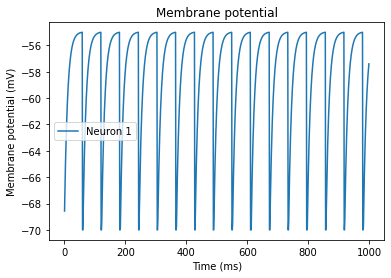

In [13]:
'''
One neuron example
------------------
This script simulates a neuron driven by a constant external current
and records its membrane potential.
'''

import nest
import nest.voltage_trace
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

neuron = nest.Create("iaf_psc_alpha")
voltmeter = nest.Create("voltmeter")

#  set the current to 376.0pA, which is the value that causes periodic spikes of neurons
nest.SetStatus(neuron,"I_e",376.0)
nest.SetStatus(voltmeter,[{"withgid": True}])

nest.Connect(voltmeter, neuron)

nest.Simulate(1000.0)

nest.voltage_trace.from_device(voltmeter)

In [14]:
# Query the constant background current value
nest.GetStatus(neuron, "I_e")
# Query the values of reset potential and neuron threshold, and receive the results as nested tuples
nest.GetStatus(neuron, ["V_reset", "V_th"])

((-70.0, -55.0),)

<function matplotlib.pyplot.show(*args, **kw)>

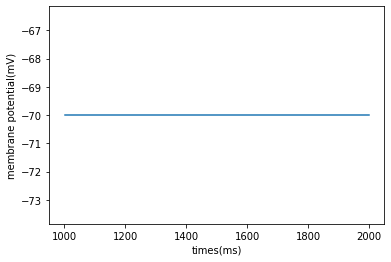

In [15]:
import pylab as pl
import nest

neuron = nest.Create("iaf_psc_exp")
voltmeter = nest.Create('voltmeter')
spikegenerator = nest.Create('spike_generator')

#let it spike 
nest.SetStatus(spikegenerator, {'spike_times': [10.0,50.0]})

nest.Connect(spikegenerator, neuron, syn_spec={'weight': 1E3})
nest.Connect(voltmeter,neuron)

nest.Simulate(1000.0)

# read out recording time and voltage from voltmeter and plot them
times = nest.GetStatus(voltmeter)[0]['events']['times']
voltage = nest.GetStatus(voltmeter)[0]['events']['V_m']
pl.plot(times, voltage)
pl.xlabel('times(ms)'); pl.ylabel('membrane potential(mV)')
pl.show

[52.5]


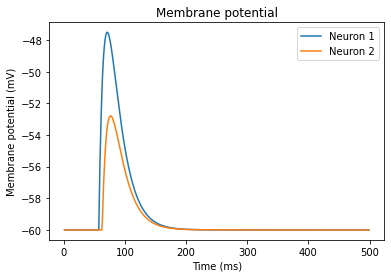

In [16]:
#*******************************************************************
#
#   A leaky integrate-and-fire neuron is created.
#   It gets a spike input at time t=55 ms
#   There is also an optional step current input at time t=50 ms that forces the neuron to spike
#
#*******************************************************************
from numpy import *
import pylab
import nest
import nest.voltage_trace
import nest.raster_plot

pylab.close('all')


###########################################
#  Parameter for the LIF neuron
###########################################
Rm = 10.0  # [MOhms]
Cm = 2000.  # [pF]
tau_m = Rm*Cm/1000.0  # membrane time constant [ms] = 20
tau_s = 10.0     # synaptic time constant [ms]
Trefract = 10.   # The refractory period of the LIF neuron [ms]
Vthresh = -45.   # The threshold potential of the LIF neuron [mV]
Vresting = -60.  # The resting potential of the LIF neuron [mV]

nrn_parameter_dict = {"V_m": Vresting,     # Membrane potential in mV
                      "E_L": Vresting,     # Resting membrane potential in mV
                      "C_m": Cm,           # Capacity of the membrane in pF
                      "tau_m": tau_m,      # Membrane time constant in ms
                      "t_ref": Trefract,   # Duration of refractory period in ms
                      "V_th": Vthresh,     # Spike threshold in mV
                      "V_reset": Vresting, # Reset potential of the membrane in mV

                      "tau_syn_ex": tau_s, # Time constant of the excitatory synaptic current in ms
                      "I_e": 0.0           # No constant external input current
                      }
# The other neuron parameters have default values.


# Reset the NEST Simulator
nest.ResetKernel()

###################################
# Create nodes
###################################

# Create the IAF neuron, see http://www.nest-simulator.org/cc/iaf_psc_exp/
neuron = nest.Create('iaf_psc_exp', 1, nrn_parameter_dict)
neuron2 = nest.Create('iaf_psc_exp', 1, nrn_parameter_dict)

# Create inputs
t_spike_input = 55.
t_step = 50.
step_duration = 0.5
step_amplitude = 60790.
# step_amplitude = 0.

#sine = nest.Create('ac_generator',1,{'amplitude':100.0,'frequency':2.0})
spike_gen = nest.Create("spike_generator", params={"spike_times": array([t_spike_input])})
step_gen = nest.Create('step_current_generator')
nest.SetStatus(step_gen, {'amplitude_times': array([t_step, t_step+step_duration]),
                          'amplitude_values': array([step_amplitude, 0.])})
# step_amplitude is in [pA]
# needs a large value to produce a spike

# Create voltmeter and spike recorder
voltmeter = nest.Create('voltmeter', 1, {'withgid': True})
spike_rec = nest.Create('spike_detector')

###################################
# Connect nodes
###################################

# Connect spike generator to neuron
# Note: The connection weight is given in [pA]
spike_gen_syn_spec = {'delay': 2., 'weight': 5000.}
nest.Connect(spike_gen, neuron, syn_spec=spike_gen_syn_spec)
nest.Connect(spike_gen, neuron2, syn_spec=spike_gen_syn_spec)

# Connect current step input step_gen to the neuron
# Note: The current amplitudes as defined above are multiplied with the weight.
nest.Connect(step_gen, neuron2, syn_spec={'delay': 2.})

# Connect voltmeter and spike recorder to neuron
nest.Connect(voltmeter, neuron)
nest.Connect(voltmeter, neuron2)
nest.Connect(neuron2, spike_rec)

###################################
# Now simulate
###################################
nest.Simulate(500.0)

###################################
# Analyze results and make plots
###################################


# Extract spikes voltage
spikes = nest.GetStatus(spike_rec)[0]['events']['times']
print(spikes)  # printing spikes for second experiment (neuron2)
# events = nest.GetStatus(spike_rec, 'events')
vm = nest.GetStatus(voltmeter, 'events')[0]['V_m']

# etc.
# Plot results
nest.voltage_trace.from_device(voltmeter)
pylab.show()

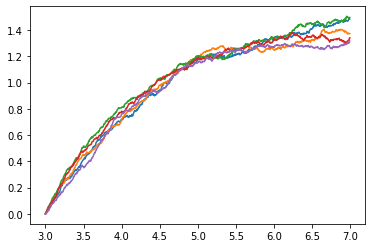

In [28]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt

num_sims = 5 ### display five runs

t_init = 3
t_end  = 7
N      = 1000 ### Compute 1000 grid points
dt     = float(t_end - t_init) / N 
y_init = 0

c_theta = 0.7
c_mu    = 1.5
c_sigma = 0.06

def mu(y, t): 
    """Implement the Ornstein–Uhlenbeck mu.""" ## = \theta (\mu-Y_t)
    return c_theta * (c_mu - y)

def sigma(y, t): 
    """Implement the Ornstein–Uhlenbeck sigma.""" ## = \sigma
    return c_sigma


def dW(delta_t): 
    """Sample a random number at each call."""
    return np.random.normal(loc = 0.0, scale = np.sqrt(delta_t))

ts = np.arange(t_init, t_end, dt)
ys = np.zeros(N)

ys[0] = y_init

for trial in range(num_sims):
    for i in range(1, ts.size):
        t = (i-1) * dt
        y = ys[i-1]
        ys[i] = y + mu(y, t) * dt + sigma(y, t) * dW(dt)
    plt.plot(ts, ys)

plt.show()


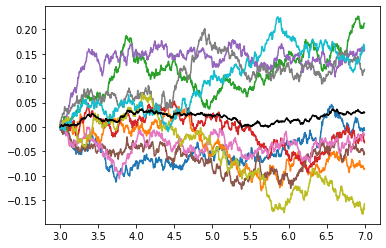

In [29]:
import numpy as np
# import matplotlib.pyplot as plt
import pylab as pl

num_sims = 10 ### display five runs

t_init = 3
t_end  = 7
N      = 1000 ### Compute 1000 grid points
dt     = float(t_end - t_init) / N 
y_init = 0

c_theta = 0.7
c_mu    = 1.5
c_sigma = 0.06

def mu(y, t): 
    """Implement the Ornstein–Uhlenbeck mu.""" ## = \theta (\mu-Y_t)
    return 0

def sigma(y, t): 
    """Implement the Ornstein–Uhlenbeck sigma.""" ## = \sigma
    return c_sigma


def dW(delta_t): 
    """Sample a random number at each call."""
    return np.random.normal(loc = 0.0, scale = np.sqrt(delta_t))

ts = np.arange(t_init, t_end, dt)
ys = np.zeros(N)

ys[0] = y_init
y_mean=np.zeros(N)
for trial in range(num_sims):
    for i in range(1, ts.size):
        t = (i-1) * dt
        y = ys[i-1]
        ys[i] = y + mu(y, t) * dt + sigma(y, t) * dW(dt)
    pl.figure(1)
    pl.plot(ts, ys)
    y_mean=y_mean+ys
y_mean=y_mean/num_sims
pl.plot(ts, y_mean,'black')
pl.show()

In [31]:
import nest
import numpy as np
import matplotlib.pyplot as plt
#local synaptic inputs
C = 20
#number of local and remote excitatory inputs
C_exc = int(0.8*C)
#number of local inhibitory inputs
C_inh = int(0.2*C)

#excitatory synaptic weights in pA
w_exc = 80
#inhibitory synaptic weights in pA
w_inh = -320.0

#= nu_exc = nu_inh(spikes/s)
nu_loc = 8.0
nu_ext = 3.0

sim_time = 1000


In [32]:
nest.ResetKernel()

In [33]:
#use the leaky integrate-and-fire neuron model in its default configuration
neuron = nest.Create('iaf_psc_alpha')
print('The default param values of the iaf_neuron model are', nest.GetDefaults('iaf_psc_alpha'), '\n')

#Poisson generators that represent the different inputs
pg_exc = nest.Create('poisson_generator', 1, {'rate': C_exc*nu_loc})
pg_inh = nest.Create('poisson_generator', 1, {'rate': C_inh*nu_loc})
pg_ext = nest.Create('poisson_generator', 1, {'rate': C_exc*nu_ext})


The default param values of the iaf_neuron model are {'archiver_length': 0, 'available': (999,), 'beta_Ca': 0.001, 'C_m': 250.0, 'Ca': 0.0, 'capacity': (1000,), 'E_L': -70.0, 'element_type': <SLILiteral: neuron>, 'elementsize': 640, 'frozen': False, 'global_id': 0, 'I_e': 0.0, 'instantiations': (1,), 'local': True, 'model': <SLILiteral: iaf_psc_alpha>, 'node_uses_wfr': False, 'post_trace': 0.0, 'recordables': (<SLILiteral: I_syn_ex>, <SLILiteral: I_syn_in>, <SLILiteral: V_m>, <SLILiteral: weighted_spikes_ex>, <SLILiteral: weighted_spikes_in>), 'supports_precise_spikes': False, 'synaptic_elements': {}, 't_ref': 2.0, 't_spike': -1.0, 'tau_Ca': 10000.0, 'tau_m': 10.0, 'tau_minus': 20.0, 'tau_minus_triplet': 110.0, 'tau_syn_ex': 2.0, 'tau_syn_in': 2.0, 'thread': 0, 'thread_local_id': -1, 'type_id': <SLILiteral: iaf_psc_alpha>, 'V_m': -70.0, 'V_min': -inf, 'V_reset': -70.0, 'V_th': -55.0, 'vp': -1} 



In [34]:
# Spike detector to recors spikes fron the neuron
sd = nest.Create('spike_detector', 1, {'to_file': False, 'to_memory': True})

In [35]:
# Connect the poisson generator to neuron
nest.Connect(pg_exc, neuron, syn_spec={'weight': w_exc})
nest.Connect(pg_inh, neuron, syn_spec={'weight': w_inh})
nest.Connect(pg_ext, neuron, syn_spec={'weight': w_exc})

In [36]:
# Connect the neuron to the spike detector
nest.Connect(neuron, sd)

In [37]:
# Simulate 
nest.Simulate(sim_time)

In [38]:
#Analyse record spike data
n_spikes = nest.GetStatus(sd, 'n_events')[0]
t_spikes = nest.GetStatus(sd, 'events')[0]['times']

print('Total num of spikes:', n_spikes, '\n')
print('The last 100 spikes occured at:\n', t_spikes[-100:], '\n')

Total num of spikes: 0 

The last 100 spikes occured at:
 [] 



In [39]:
print('rate:', n_spikes/sim_time *1000.0, '\n')

isis = t_spikes[1:]-t_spikes[:1]
print('CV ISI:', np.std(isis)/np.mean(isis))

rate: 0.0 

CV ISI: nan
